In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
from scipy.stats import kde
from tqdm import tqdm

from research.datasets import AutoLoadedDataset
from research.evaluator import evaluate, stats_to_df
from research.regression import LinearFitSKL, FCNN

In [2]:
if not os.path.exists('export'):
    os.mkdir('export')
if not os.path.exists('export/eps'):
    os.mkdir('export/eps')

plt.rcParams.update({
    "savefig.facecolor": (1, 1, 1, 1),
    "figure.figsize": (7, 4),
})

def save(fname):
    plt.savefig(f'export/lin-tof-{fname}', dpi=300)
    plt.savefig(f'export/eps/lin-tof-{fname}.eps', dpi=1000, format='eps')

In [3]:
loaded = AutoLoadedDataset.load(seed=0, search_path='datasets/auto')

Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\17_lmpavw.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\52_svmguide1.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\53_fourclass_scale.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\58_sarcasm_detection.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\77_WorkersCompensation.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\78_shill-bidding.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\79_art_daily_nojump3.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\80_art_daily_small_noise2.arff
Loaded 74 datasets


In [4]:
RESULTS = {}
for name, dataset in tqdm(loaded.items()):
    eval_stats = evaluate(dataset, LinearFitSKL, retrain_on_filtered=True)
    RESULTS[name] = stats_to_df(
        eval_stats,
        [
            'target_coverage',
            'expected_coverage',
            'coverage',
            'mse_expected',
            'mse_filtered',
            'mse_prop_base',
            'comparison_loss',
        ],
        name
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [02:26<00:00,  1.99s/it]


In [5]:
data = pd.concat(RESULTS.values(), ignore_index=True)
data

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
0,0_kin8nm,0.1,0.205858,0.203907,0.017611,0.022122,0.523405,0.020315
1,0_kin8nm,0.2,0.205858,0.203907,0.017611,0.022122,0.523405,0.020315
2,0_kin8nm,0.3,0.315704,0.310134,0.019061,0.022923,0.545366,0.020315
3,0_kin8nm,0.4,0.445281,0.442308,0.023741,0.026237,0.616658,0.020315
4,0_kin8nm,0.5,0.530309,0.522589,0.025927,0.029556,0.710780,0.020315
...,...,...,...,...,...,...,...,...
735,9_wine_quality,0.6,0.673763,0.662818,0.394021,0.421795,0.818837,0.386517
736,9_wine_quality,0.7,0.800718,0.809084,0.427599,0.435375,0.846466,0.386517
737,9_wine_quality,0.8,0.800718,0.809084,0.427599,0.435375,0.846466,0.386517
738,9_wine_quality,0.9,0.929726,0.931486,0.492920,0.476015,0.917026,0.386517


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


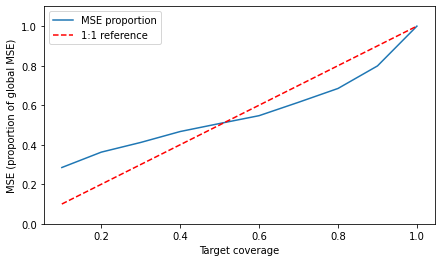

In [6]:
stats = data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

plt.plot(stats[:,0], stats[:,1], label='MSE proportion')
plt.plot([0.1, 1], [0.1, 1], 'r--', label='1:1 reference')

plt.xlabel('Target coverage')
plt.ylabel('MSE (proportion of global MSE)')
plt.ylim((0, 1.1))
plt.legend()
save('coverage-proportion reference')
plt.show()

In [7]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

array([[0.1       , 0.28474427],
       [0.2       , 0.362527  ],
       [0.3       , 0.41159691],
       [0.4       , 0.46680896],
       [0.5       , 0.5073613 ],
       [0.6       , 0.54702288],
       [0.7       , 0.61478712],
       [0.8       , 0.68469547],
       [0.9       , 0.79864921],
       [1.        , 1.        ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


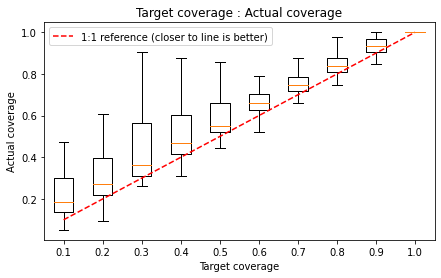

In [8]:
coverages = data.groupby('target_coverage').agg({
    'coverage': lambda x: list(x)
}).reset_index()['coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Actual coverage')
plt.title('Target coverage : Actual coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-actual')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


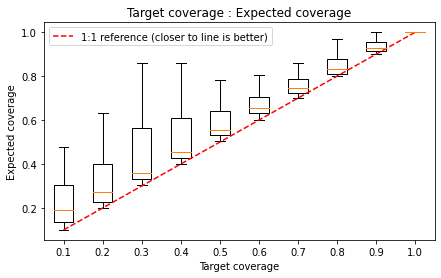

In [9]:
coverages = data.groupby('target_coverage').agg({
    'expected_coverage': lambda x: list(x)
}).reset_index()['expected_coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Expected coverage')
plt.title('Target coverage : Expected coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-expected')
plt.show()

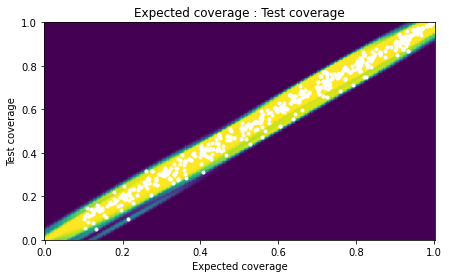

0.9964061723708724

In [10]:
x, y = data['expected_coverage'], data['coverage']

nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Expected coverage : Test coverage')
plt.xlabel('Expected coverage')
plt.ylabel('Test coverage')
save('expected-actual coverage heatmap')
plt.show()

x.corr(y)

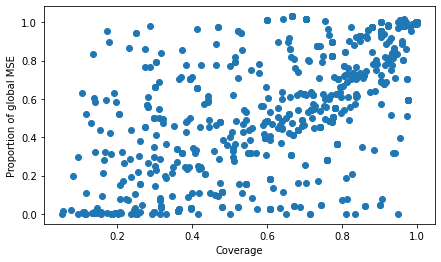

In [11]:
plt.scatter(data['coverage'], data['mse_prop_base'])

plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
plt.show()

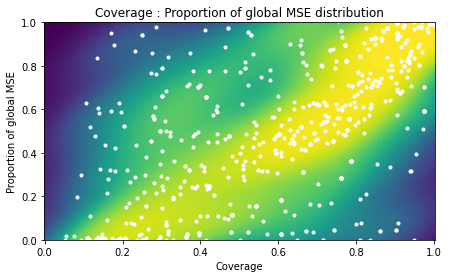

In [12]:
x, y = data['coverage'], data['mse_prop_base']
nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Coverage : Proportion of global MSE distribution')
plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
save('coverage-proportion heatmap')
plt.show()

In [13]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
})

,mse_prop_base
target_coverage,
0.1,0.284744
0.2,0.362527
0.3,0.411597
0.4,0.466809
0.5,0.507361
0.6,0.547023
0.7,0.614787
0.8,0.684695
0.9,0.798649


In [14]:
# Ones where we did well
data[np.abs(data['mse_prop_base'] / data['coverage']) < 0.05]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
20,11_analcatdata_supreme,0.1,0.256990,0.250000,0.012860,1.972152e-31,5.780737e-31,0.007272
21,11_analcatdata_supreme,0.2,0.256990,0.250000,0.012860,1.972152e-31,5.780737e-31,0.007272
90,19_strikes,0.1,0.194149,0.196787,0.006471,7.060800e-04,5.850680e-03,0.009410
91,19_strikes,0.2,0.202128,0.208835,0.007205,7.120246e-04,5.841721e-03,0.009410
127,21_cpu_small,0.8,0.860456,0.861416,29.855287,9.780667e+00,4.270449e-02,8.240140
...,...,...,...,...,...,...,...,...
696,76_auml_eml_1_d,0.7,0.727834,0.713584,0.005572,7.966971e-03,1.987814e-05,0.023505
697,76_auml_eml_1_d,0.8,0.825581,0.810147,0.010154,1.335743e-02,1.039319e-06,0.023505
698,76_auml_eml_1_d,0.9,0.956032,0.948172,0.025149,3.199184e-02,6.152101e-07,0.023505
710,81_MiamiHousing2016,0.1,0.140550,0.132986,0.054535,6.718062e-03,3.673155e-03,0.195951


In [15]:
# Ones where we did bad
data[(data['mse_prop_base'] / data['coverage']) > 5]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
10,10_wind,0.1,0.126489,0.135413,5.439970e+00,9.519779e+00,0.835596,9.878771e+00
50,14_pm10,0.1,0.156146,0.105528,2.123481e+04,4.332404e+04,0.628763,3.902915e+04
51,14_pm10,0.2,0.225914,0.170854,2.311299e+04,5.739563e+04,0.951535,3.902915e+04
60,15_pollen,0.1,0.183196,0.178038,1.117391e+06,1.212443e+06,0.898096,1.320404e+06


In [16]:
# Success stories
data[(data['mse_prop_base'] < 0.2) & (data['coverage'] > 0.8)]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
27,11_analcatdata_supreme,0.8,0.810855,0.809877,6.973388e-02,3.632797e-02,1.874129e-01,7.271741e-03
127,21_cpu_small,0.8,0.860456,0.861416,2.985529e+01,9.780667e+00,4.270449e-02,8.240140e+00
128,21_cpu_small,0.9,0.902970,0.901099,3.272501e+01,1.063496e+01,4.629936e-02,8.240140e+00
467,54_COMET_MC_SAMPLE,0.8,0.841610,0.834500,4.518680e-04,0.000000e+00,0.000000e+00,5.073666e-03
517,5_house_8L,0.8,0.802721,0.812137,5.865134e+08,5.579363e+08,7.815944e-02,8.821172e+08
518,5_house_8L,0.9,0.905054,0.906397,8.099710e+08,6.688470e+08,7.693620e-02,8.821172e+08
697,76_auml_eml_1_d,0.8,0.825581,0.810147,1.015386e-02,1.335743e-02,1.039319e-06,2.350480e-02
698,76_auml_eml_1_d,0.9,0.956032,0.948172,2.514869e-02,3.199184e-02,6.152101e-07,2.350480e-02
727,8_cpu_small,0.8,0.860456,0.861416,2.985529e+01,9.780667e+00,4.270449e-02,8.236983e+00
728,8_cpu_small,0.9,0.902970,0.901099,3.272501e+01,1.063496e+01,4.629936e-02,8.236983e+00


In [17]:
def plot_stats(name):
    stats = RESULTS[name]

    plt.plot(stats['coverage'], stats['mse_filtered'], marker='^', label='Actual MSE')
    plt.plot(stats['coverage'], stats['mse_expected'], marker='o', label='Predicted MSE')
    plt.axhline(stats['comparison_loss'][0], linestyle='--', color='r', label='Random forest performance')

    plt.xlabel('Coverage')
    plt.ylabel('MSE')
    plt.title(f'Predicted and actual MSE for {name}')
    plt.legend()
    save(name)
    plt.show()

Epoch 1: loss=0.6020
Epoch 2: loss=0.5244
Epoch 3: loss=0.5024
Epoch 4: loss=0.4884
Epoch 5: loss=0.4758


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


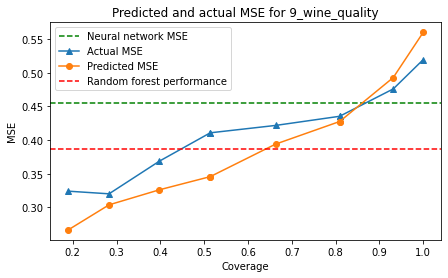

In [18]:
wines = loaded['9_wine_quality']
fitter_nn = FCNN(wines.x_train, wines.y_train, [64, 64, 64], epochs=5, device='cpu')

loss = np.square(fitter_nn.predict(wines.x_test) - np.expand_dims(wines.y_test, -1)).mean()

plt.axhline(loss, 0, 1, linestyle='--', color='g', label='Neural network MSE')

plot_stats('9_wine_quality')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


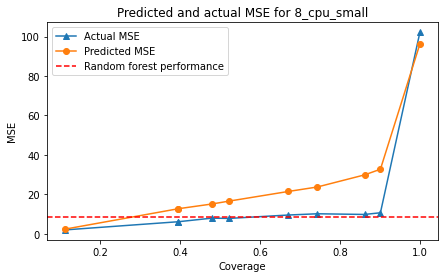

In [19]:
plot_stats('8_cpu_small')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


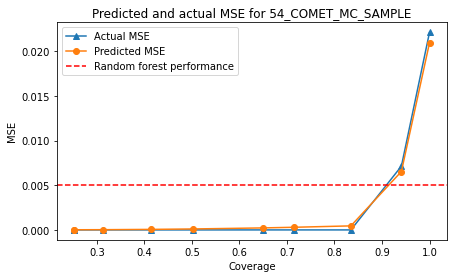

In [20]:
plot_stats('54_COMET_MC_SAMPLE')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


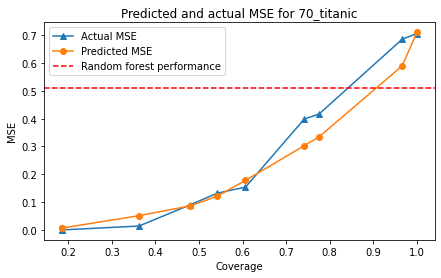

In [21]:
plot_stats('70_titanic')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


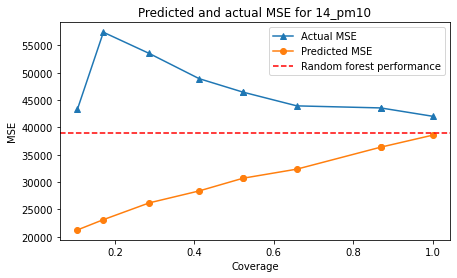

In [22]:
plot_stats('14_pm10')

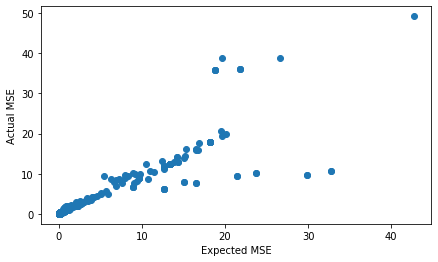

In [23]:
mask = (data['mse_expected'] < 100) & (data['mse_filtered'] < 100)

plt.scatter(data['mse_expected'][mask], data['mse_filtered'][mask])
plt.xlabel('Expected MSE')
plt.ylabel('Actual MSE')
save('expected to actual')
plt.show()

In [24]:
data['coverage'].corr(data['mse_prop_base'])

0.6673963789069528

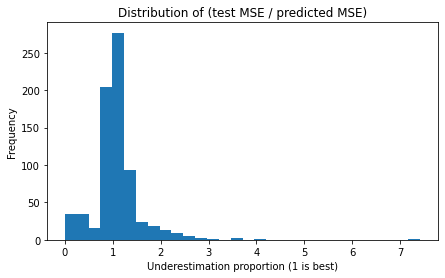

In [25]:
plt.hist(data['mse_filtered'] / data['mse_expected'], bins=30)

plt.title('Distribution of (test MSE / predicted MSE)')
plt.xlabel('Underestimation proportion (1 is best)')
plt.ylabel('Frequency')
save('underestimation dist')
plt.show()

In [26]:
ratios =  data['mse_filtered'] / data['mse_expected']
ratios.mean(), ratios.std()

(1.0897343327716575, 0.5391471773373955)

In [27]:
ratios.mean() + 1.96 * ratios.std()

2.1464628003529524

In [28]:
(ratios > 1.5).mean()

0.10540540540540541